In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings(action='ignore')
 
 
import matplotlib
from matplotlib import font_manager, rc
import platform
 
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False

# 데이터 확인

In [ ]:
# 최종 데이터 불러오기
df = pd.read_csv('서울시_최종.csv',encoding='cp949')

In [ ]:
# 데이터 확인
df.head(3)

,시군구,행정구역,인구수,가구수,세대당인구수,일인가구수,기초수급가구수,소득분위,재활용량,쓰레기발생량,상업용,주거용,분리수거함개수
0,종로구,청운효자동,12024.0,5345.0,2.31,1378.0,131.0,8.0,10.251306,20.156785,277.0,1356.0,82.0
1,종로구,사직동,9371.0,4577.0,1.99,1487.0,109.0,9.0,7.989437,15.709351,492.0,689.0,27.0
2,종로구,삼청동,2498.0,1388.0,2.01,380.0,31.0,7.0,2.129721,4.187596,340.0,527.0,3.0


In [ ]:
# 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시군구      424 non-null    object 
 1   행정구역     424 non-null    object 
 2   인구수      424 non-null    float64
 3   가구수      424 non-null    float64
 4   세대당인구수   424 non-null    float64
 5   일인가구수    424 non-null    float64
 6   기초수급가구수  424 non-null    float64
 7   소득분위     424 non-null    float64
 8   재활용량     424 non-null    float64
 9   쓰레기발생량   424 non-null    float64
 10  상업용      424 non-null    float64
 11  주거용      424 non-null    float64
 12  분리수거함개수  424 non-null    float64
dtypes: float64(11), object(2)
memory usage: 43.2+ KB


In [ ]:
# 결측값 확인 - 없음
df.isnull().sum()

시군구        0
행정구역       0
인구수        0
가구수        0
세대당인구수     0
일인가구수      0
기초수급가구수    0
소득분위       0
재활용량       0
쓰레기발생량     0
상업용        0
주거용        0
분리수거함개수    0
dtype: int64

# EDA

### 변수 분포 확인 및 이상치 탐색

In [ ]:
최종df = df.copy()

In [ ]:
최종df

,시군구,행정구역,인구수,가구수,세대당인구수,일인가구수,기초수급가구수,소득분위,재활용량,쓰레기발생량,상업용,주거용,분리수거함개수
0,종로구,청운효자동,12024.0,5345.0,2.31,1378.0,131.0,8.0,10.251306,20.156785,277.0,1356.0,82.0
1,종로구,사직동,9371.0,4577.0,1.99,1487.0,109.0,9.0,7.989437,15.709351,492.0,689.0,27.0
2,종로구,삼청동,2498.0,1388.0,2.01,380.0,31.0,7.0,2.129721,4.187596,340.0,527.0,3.0
3,종로구,부암동,9703.0,4268.0,2.29,1129.0,114.0,7.0,8.272490,16.265909,186.0,1093.0,102.0
4,종로구,평창동,18204.0,7497.0,2.43,1302.0,97.0,8.0,15.520191,30.516810,191.0,1688.0,209.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,강동구,성내2동,23961.0,12458.0,1.87,5143.0,681.0,6.0,8.524224,15.570228,224.0,1481.0,41.0
420,강동구,성내3동,23377.0,10286.0,2.20,3134.0,483.0,6.0,8.316463,15.190736,228.0,967.0,78.0
421,강동구,길동,46019.0,20473.0,2.13,6909.0,1083.0,6.0,16.371447,29.903858,352.0,1396.0,181.0
422,강동구,둔촌1동,134.0,164.0,1.65,6.0,1.0,7.0,0.047671,0.087075,5.0,3.0,0.0


In [ ]:
# 이상치 처리

# 필요하지 않은 열 삭제 (쓰레기발생량은 종속변수로 사용)
X_col = 최종df.drop(['시군구','행정구역','쓰레기발생량'],axis=1,inplace=False).columns.tolist() 

# IQR을 활용한 이상치 대체
# 최소제한선과 최대제한선을 넘어가는 값들을 이상치로 판단하고 대체함
for col in X_col:
    Q3 = 최종df[col].describe()['75%']
    Q1 = 최종df[col].describe()['25%']
    IQR = Q3 - Q1  # 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이
    최종df[col].loc[최종df[col]<  Q1 - IQR * 3] = Q1 - IQR * 3
    최종df[col].loc[최종df[col]>  Q3 + IQR * 3] = Q3 + IQR * 3

In [ ]:
# 소득분위 1인 데이터값 1개 있음, 이상치로 판단하여 5로 대체
# 보고서에 안넣어도 됨

최종df.loc[최종df['소득분위']==1,'소득분위']=5

### 변수 표준화

In [ ]:
# robust 스케일링 : 이상치에 효과적

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
최종df[X_col] = scaler.fit_transform(최종df[X_col])

In [ ]:
# 스케일링 된 DataFrame 확인

최종df

,시군구,행정구역,인구수,가구수,세대당인구수,일인가구수,기초수급가구수,소득분위,재활용량,쓰레기발생량,상업용,주거용,분리수거함개수
0,종로구,청운효자동,-0.900942,-0.827648,0.252874,-0.642254,-0.697011,0.5,0.399254,20.156785,0.409857,0.641932,0.338028
1,종로구,사직동,-1.144108,-0.971799,-0.482759,-0.596243,-0.737471,1.0,-0.030540,15.709351,1.525292,-0.143698,-0.694836
2,종로구,삼청동,-1.774066,-1.570363,-0.436782,-1.063529,-0.880920,0.0,-1.143986,4.187596,0.736706,-0.334511,-1.145540
3,종로구,부암동,-1.113678,-1.029797,0.206897,-0.747362,-0.728276,0.0,0.023245,16.265909,-0.062257,0.332155,0.713615
4,종로구,평창동,-0.334502,-0.423725,0.528736,-0.674335,-0.759540,0.5,1.400432,30.516810,-0.036316,1.032980,2.723005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,강동구,성내2동,0.193167,0.507437,-0.758621,0.947024,0.314483,-0.5,0.071079,15.570228,0.134890,0.789164,-0.431925
420,강동구,성내3동,0.139639,0.099761,0.000000,0.098987,-0.049655,-0.5,0.031601,15.190736,0.155642,0.183746,0.262911
421,강동구,길동,2.214935,2.011825,-0.160920,1.692486,1.053793,-0.5,1.562185,29.903858,0.798962,0.689046,2.197183
422,강동구,둔촌1동,-1.990743,-1.800103,-1.264368,-1.221401,-0.936092,0.0,-1.539611,0.087075,-1.001297,-0.951708,-1.201878


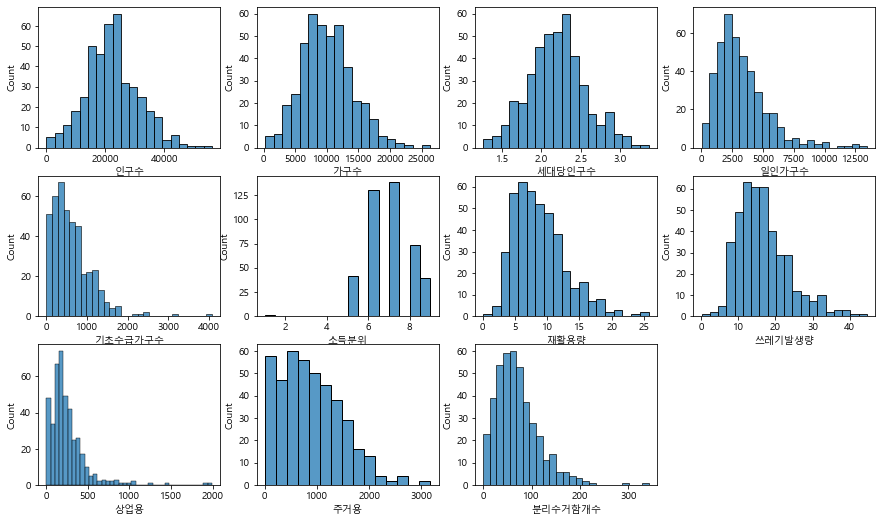

In [ ]:
# 각 변수에 대한 히스토그램을 그려 분포 확인

plt.figure(figsize=(15,15))
for idx,col in enumerate(최종df.columns.tolist()[2:]):
    plt.subplot(5,4,idx+1)
    sns.histplot(df[col])
    #plt.grid()
plt.show()

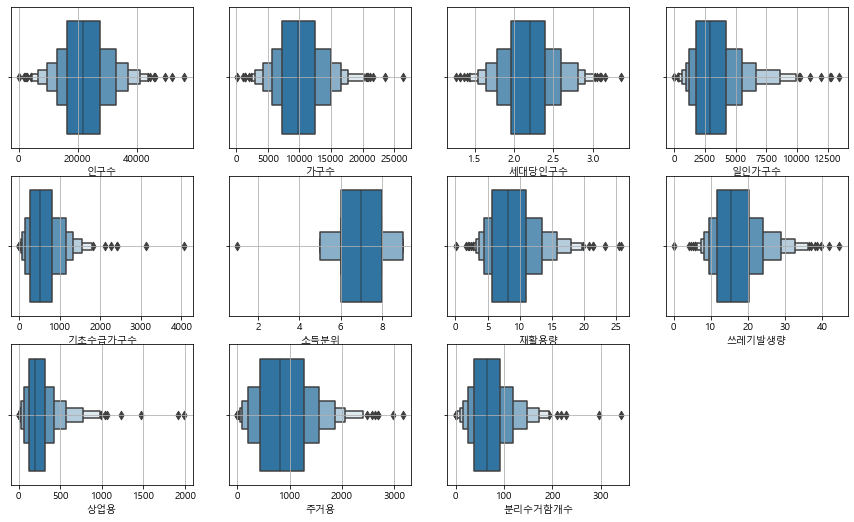

In [ ]:
# 각 변수에 대한 boxplot을 그려 분포 확인

plt.figure(figsize=(15,15))
for idx,col in enumerate(최종df.columns.tolist()[2:]):
    plt.subplot(5,4,idx+1)
    sns.boxenplot(df[col])
    plt.grid()
plt.show()

### 변수 간 관계 확인

In [ ]:
# 상관계수 행렬
최종df.corr()

,인구수,가구수,세대당인구수,일인가구수,기초수급가구수,소득분위,재활용량,쓰레기발생량,상업용,주거용,분리수거함개수
인구수,1.000000,0.874846,0.287441,0.466121,0.378802,0.074683,0.640025,0.673741,0.048372,0.206847,0.608941
가구수,0.874846,1.000000,-0.094113,0.750634,0.502569,-0.113679,0.615666,0.603358,0.255910,0.426366,0.514570
세대당인구수,0.287441,-0.094113,1.000000,-0.608275,-0.246743,0.489863,0.020118,0.103860,-0.560367,-0.470189,0.307121
일인가구수,0.466121,0.750634,-0.608275,1.000000,0.401680,-0.298379,0.432143,0.374437,0.489606,0.508925,0.169975
기초수급가구수,0.378802,0.502569,-0.246743,0.401680,1.000000,-0.473179,0.266712,0.182790,0.044978,0.418206,0.093420
소득분위,0.074683,-0.113679,0.489863,-0.298379,-0.473179,1.000000,0.004586,0.141860,-0.055879,-0.561539,0.197348
재활용량,0.640025,0.615666,0.020118,0.432143,0.266712,0.004586,1.000000,0.907778,0.179566,0.243248,0.357733
쓰레기발생량,0.673741,0.603358,0.103860,0.374437,0.182790,0.141860,0.907778,1.000000,0.219117,0.142884,0.441818
상업용,0.048372,0.255910,-0.560367,0.489606,0.044978,-0.055879,0.179566,0.219117,1.000000,0.355394,0.042569
주거용,0.206847,0.426366,-0.470189,0.508925,0.418206,-0.561539,0.243248,0.142884,0.355394,1.000000,0.011416


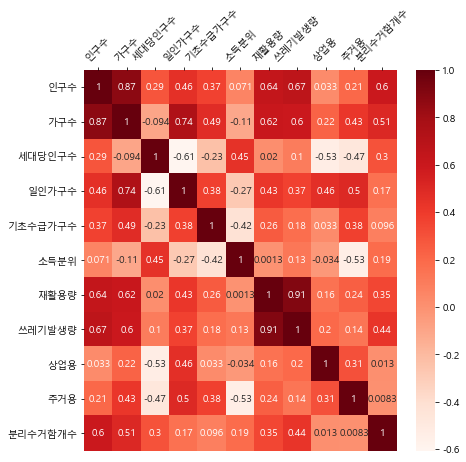

In [ ]:
# 상관계수에 대한 히트맵을 그려 각 변수들의 상관관계 파악 (EDA)

plt.figure(figsize=(7,7))
heat = sns.heatmap(df.corr(),annot=True,cmap='Reds')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
heat.set_xticklabels(heat.get_xticklabels(), rotation=45) 
# plt.show()

plt.savefig("상관관계.png",dpi=200,facecolor=heat.get_facecolor(),transparent=True,bbox_inches='tight')

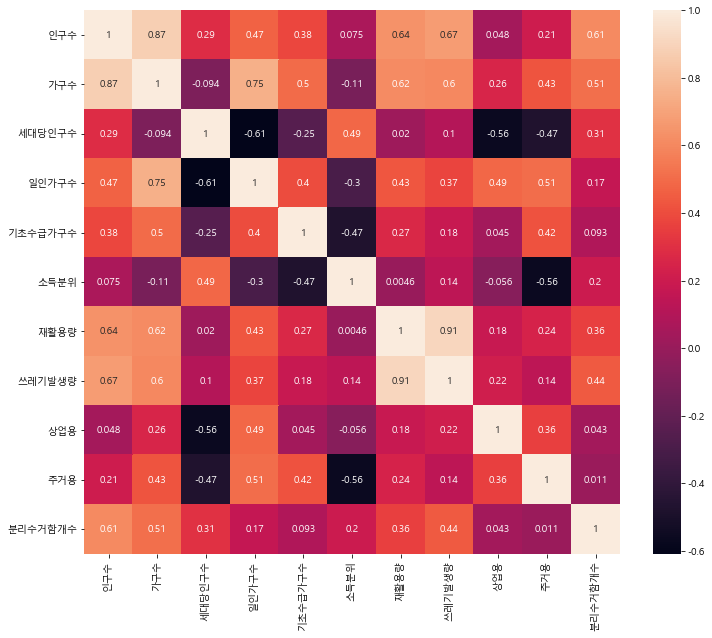

In [ ]:
# 상관계수 히트맵 (색깔만 바꾼 것)

plt.figure(figsize=(12,10))
sns.heatmap(최종df.corr(),annot=True)
plt.show()

## 회귀분석
- 쓰레기 발생량이 많은 지역의 자원순환가게 이용률이 높다고 가정
- 쓰레기 발생량을 종속변수, 나머지 변수를 독립변수로 두고 회귀분석 실행

1. 전체 변수에 대한 회귀분석 진행

2. P-value가 높은 변수부터 차례로 제거

3. 각 변수의 VIF 계수를 출력하여 다중공선성 확인

4. 모든 P-value가 0.005 이하가 될 때까지 (1, 2, 3) 의 과정 반복

In [ ]:
최종df.columns

Index(['시군구', '행정구역', '인구수', '가구수', '세대당인구수', '일인가구수', '기초수급가구수', '소득분위',
       '재활용량', '쓰레기발생량', '상업용', '주거용', '분리수거함개수'],
      dtype='object')

In [ ]:
최종df

,시군구,행정구역,인구수,가구수,세대당인구수,일인가구수,기초수급가구수,소득분위,재활용량,쓰레기발생량,상업용,주거용,분리수거함개수
0,종로구,청운효자동,-0.900942,-0.827648,0.252874,-0.642254,-0.697011,0.5,0.399254,20.156785,0.409857,0.641932,0.338028
1,종로구,사직동,-1.144108,-0.971799,-0.482759,-0.596243,-0.737471,1.0,-0.030540,15.709351,1.525292,-0.143698,-0.694836
2,종로구,삼청동,-1.774066,-1.570363,-0.436782,-1.063529,-0.880920,0.0,-1.143986,4.187596,0.736706,-0.334511,-1.145540
3,종로구,부암동,-1.113678,-1.029797,0.206897,-0.747362,-0.728276,0.0,0.023245,16.265909,-0.062257,0.332155,0.713615
4,종로구,평창동,-0.334502,-0.423725,0.528736,-0.674335,-0.759540,0.5,1.400432,30.516810,-0.036316,1.032980,2.723005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,강동구,성내2동,0.193167,0.507437,-0.758621,0.947024,0.314483,-0.5,0.071079,15.570228,0.134890,0.789164,-0.431925
420,강동구,성내3동,0.139639,0.099761,0.000000,0.098987,-0.049655,-0.5,0.031601,15.190736,0.155642,0.183746,0.262911
421,강동구,길동,2.214935,2.011825,-0.160920,1.692486,1.053793,-0.5,1.562185,29.903858,0.798962,0.689046,2.197183
422,강동구,둔촌1동,-1.990743,-1.800103,-1.264368,-1.221401,-0.936092,0.0,-1.539611,0.087075,-1.001297,-0.951708,-1.201878


In [ ]:
# 불필요한 column 제거

X_col = 최종df.drop(['시군구','행정구역','쓰레기발생량'],axis=1).columns.tolist()

In [ ]:
X_col

['인구수',
 '가구수',
 '세대당인구수',
 '일인가구수',
 '기초수급가구수',
 '소득분위',
 '재활용량',
 '상업용',
 '주거용',
 '분리수거함개수']

In [ ]:
최종df[X_col]

,인구수,가구수,세대당인구수,일인가구수,기초수급가구수,소득분위,재활용량,상업용,주거용,분리수거함개수
0,-0.900942,-0.827648,0.252874,-0.642254,-0.697011,0.5,0.399254,0.409857,0.641932,0.338028
1,-1.144108,-0.971799,-0.482759,-0.596243,-0.737471,1.0,-0.030540,1.525292,-0.143698,-0.694836
2,-1.774066,-1.570363,-0.436782,-1.063529,-0.880920,0.0,-1.143986,0.736706,-0.334511,-1.145540
3,-1.113678,-1.029797,0.206897,-0.747362,-0.728276,0.0,0.023245,-0.062257,0.332155,0.713615
4,-0.334502,-0.423725,0.528736,-0.674335,-0.759540,0.5,1.400432,-0.036316,1.032980,2.723005
...,...,...,...,...,...,...,...,...,...,...
419,0.193167,0.507437,-0.758621,0.947024,0.314483,-0.5,0.071079,0.134890,0.789164,-0.431925
420,0.139639,0.099761,0.000000,0.098987,-0.049655,-0.5,0.031601,0.155642,0.183746,0.262911
421,2.214935,2.011825,-0.160920,1.692486,1.053793,-0.5,1.562185,0.798962,0.689046,2.197183
422,-1.990743,-1.800103,-1.264368,-1.221401,-0.936092,0.0,-1.539611,-1.001297,-0.951708,-1.201878


## 회귀분석 

In [ ]:
# 종속변수 : 쓰레기발생량
# 가구수의 p-value가 가장 커서 유의하지 않으므로 제거해야함
# Adj.R-square는 0.8 이상으로 설명력이 충분함

model = smf.ols(formula = '쓰레기발생량 ~ '+'+'.join(X_col), data = 최종df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 쓰레기발생량   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     271.8
Date:                Wed, 11 Aug 2021   Prob (F-statistic):          9.82e-175
Time:                        14:15:14   Log-Likelihood:                -990.39
No. Observations:                 424   AIC:                             2003.
Df Residuals:                     413   BIC:                             2047.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6416      0.148    105.426      0.000      15.350      15.933
인구수            2.1594      0.513      4.211      0.000       1.151       3.167
가구수           -0.6617      0.602     -1.100      0.272      -1.844       0.521
세대당인구수        -0.5645      0.401     -1.408      0.160      -1.353       0.224
일인가구수         -0.6357      0.394     -1.612      0.108      -1.411       0.139
기초수급가구수       -0.2748      0.209     -1.317      0.189      -0.685       0.135
소득분위           0.8872      0.327      2.710      0.007       0.244       1.531
재활용량           7.1351      0.212     33.593      0.000       6.718       7.553
상업용            0.7380      0.178      4.141      0.000       0.388       1.088
주거용           -0.4911      0.255     -1.926      0.055      -0.992       0.010
분리수거함개수        0.4404      0.197      2.235      0.026       0.053       0.828
==============================================================================
Omnibus:                      173.450   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.327
Skew:                           1.728   Prob(JB):                    2.26e-185
Kurtosis:                       9.016   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 가구수 제거 후 다중공선성 확인

del X_col[X_col.index('가구수')]

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(최종df[X_col].values, i) for i in range(최종df[X_col].shape[1])]
vif["features"] = X_col
vif


,VIF Factor,features
0,5.797667,인구수
1,6.100306,세대당인구수
2,5.365755,일인가구수
3,1.787177,기초수급가구수
4,2.143302,소득분위
5,1.820944,재활용량
6,1.835951,상업용
7,2.021644,주거용
8,1.711383,분리수거함개수


In [ ]:
# 다중공선성 확인 후 다시 회귀
# 세대당 인구수의 p-value가 가장 크므로 제거해야 함

model = smf.ols(formula = '쓰레기발생량 ~ '+'+'.join(X_col), data = 최종df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 쓰레기발생량   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     301.7
Date:                Wed, 11 Aug 2021   Prob (F-statistic):          1.00e-175
Time:                        14:15:14   Log-Likelihood:                -991.01
No. Observations:                 424   AIC:                             2002.
Df Residuals:                     414   BIC:                             2043.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6820      0.144    109.065      0.000      15.399      15.965
인구수            1.7834      0.382      4.665      0.000       1.032       2.535
세대당인구수        -0.5525      0.401     -1.378      0.169      -1.340       0.236
일인가구수         -0.8577      0.339     -2.532      0.012      -1.524      -0.192
기초수급가구수       -0.3332      0.202     -1.651      0.100      -0.730       0.064
소득분위           0.8491      0.326      2.607      0.009       0.209       1.489
재활용량           7.1409      0.212     33.623      0.000       6.723       7.558
상업용            0.7399      0.178      4.150      0.000       0.389       1.090
주거용           -0.5525      0.249     -2.220      0.027      -1.042      -0.063
분리수거함개수        0.3979      0.193      2.059      0.040       0.018       0.778
==============================================================================
Omnibus:                      172.699   Durbin-Watson:                   0.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              838.043
Skew:                           1.723   Prob(JB):                    1.05e-182
Kurtosis:                       8.963   Cond. No.                         7.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 세대당인구수 제거
# 다중공선성 확인

del X_col[X_col.index('세대당인구수')]

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(최종df[X_col].values, i) for i in range(최종df[X_col].shape[1])]
vif["features"] = X_col
vif


,VIF Factor,features
0,3.189470,인구수
1,2.325216,일인가구수
2,1.731330,기초수급가구수
3,2.059236,소득분위
4,1.818170,재활용량
5,1.624211,상업용
6,2.000597,주거용
7,1.694772,분리수거함개수


In [ ]:
# 세대당인구수 제거 후 3차 회귀
# 기초수급 가구수의 p-value 값이 가장 크므로 제거해야 함

model = smf.ols(formula = '쓰레기발생량 ~ '+'+'.join(X_col), data = 최종df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 쓰레기발생량   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     338.5
Date:                Wed, 11 Aug 2021   Prob (F-statistic):          1.36e-176
Time:                        14:15:14   Log-Likelihood:                -991.98
No. Observations:                 424   AIC:                             2002.
Df Residuals:                     415   BIC:                             2038.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6037      0.132    118.009      0.000      15.344      15.864
인구수            1.4064      0.267      5.262      0.000       0.881       1.932
일인가구수         -0.4945      0.213     -2.320      0.021      -0.913      -0.076
기초수급가구수       -0.2622      0.195     -1.342      0.180      -0.646       0.122
소득분위           0.7414      0.316      2.343      0.020       0.119       1.363
재활용량           7.1652      0.212     33.817      0.000       6.749       7.582
상업용            0.8441      0.162      5.223      0.000       0.526       1.162
주거용           -0.5233      0.248     -2.108      0.036      -1.011      -0.035
분리수거함개수        0.3872      0.193      2.002      0.046       0.007       0.767
==============================================================================
Omnibus:                      174.707   Durbin-Watson:                   0.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              851.606
Skew:                           1.745   Prob(JB):                    1.19e-185
Kurtosis:                       9.002   Cond. No.                         4.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 기초수급가구수 제거
# 다중공선성 확인
del X_col[X_col.index('기초수급가구수')]

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(최종df[X_col].values, i) for i in range(최종df[X_col].shape[1])]
vif["features"] = X_col
vif


,VIF Factor,features
0,2.926561,인구수
1,2.308165,일인가구수
2,1.730163,소득분위
3,1.818162,재활용량
4,1.621596,상업용
5,1.993114,주거용
6,1.688546,분리수거함개수


In [ ]:
# 기초수급가구수 제거 후 4차 회귀

model = smf.ols(formula = '쓰레기발생량 ~ '+'+'.join(X_col), data = 최종df)
result = model.fit()
result.summary()

# 모든 변수 p값 유의함 --> 회귀완료

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 쓰레기발생량   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     385.8
Date:                Wed, 11 Aug 2021   Prob (F-statistic):          1.63e-177
Time:                        14:15:14   Log-Likelihood:                -992.90
No. Observations:                 424   AIC:                             2002.
Df Residuals:                     416   BIC:                             2034.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5744      0.131    119.313      0.000      15.318      15.831
인구수            1.2991      0.255      5.089      0.000       0.797       1.801
일인가구수         -0.5194      0.213     -2.444      0.015      -0.937      -0.102
소득분위           0.9039      0.293      3.089      0.002       0.329       1.479
재활용량           7.1690      0.212     33.805      0.000       6.752       7.586
상업용            0.8595      0.161      5.326      0.000       0.542       1.177
주거용           -0.5466      0.248     -2.206      0.028      -1.034      -0.059
분리수거함개수        0.4091      0.193      2.121      0.034       0.030       0.788
==============================================================================
Omnibus:                      170.689   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.823
Skew:                           1.721   Prob(JB):                    8.44e-172
Kurtosis:                       8.723   Cond. No.                         4.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 회귀분석 결과로 가구수, 세대당인구수, 기초수급가구수 제거 후 최종 df
최종df = 최종df[['시군구','행정구역']+X_col+['쓰레기발생량']]

In [ ]:
최종df.to_csv('0810최종df.csv', index=False)